In [236]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from wearsed.dataset.Recording import Recording

<Axes: >

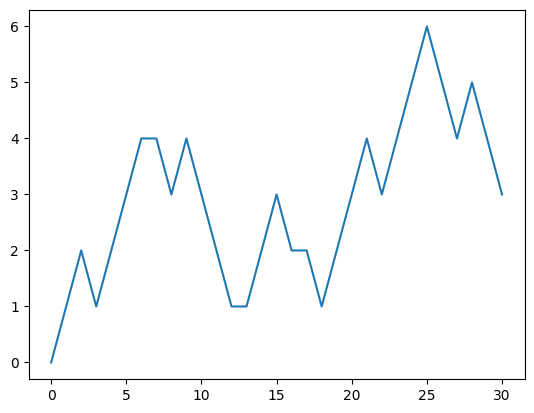

In [237]:
x = pd.Series([0,1,2,1,2,3,4,4,3,4,3,2,1,1,2,3,2,2,1,2,3,4,3,4,5,6,5,4,5,4,3])
x.plot()

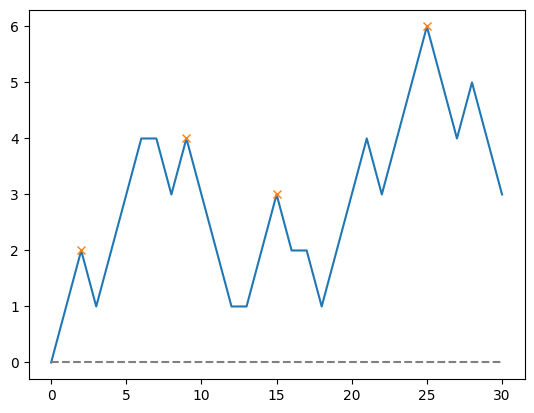

In [238]:
peaks, _ = find_peaks(x.values, distance=5)
plt.plot(x.values)
plt.plot(peaks, x.values[peaks], "x")
plt.plot(np.zeros_like(x.values), "--", color="gray")
plt.show()

In [239]:
r1 = Recording(1)
pleth = r1.psg['Pleth']
start, duration = 10000, 20
x = pleth[start*256:(start+duration)*256]

<Axes: >

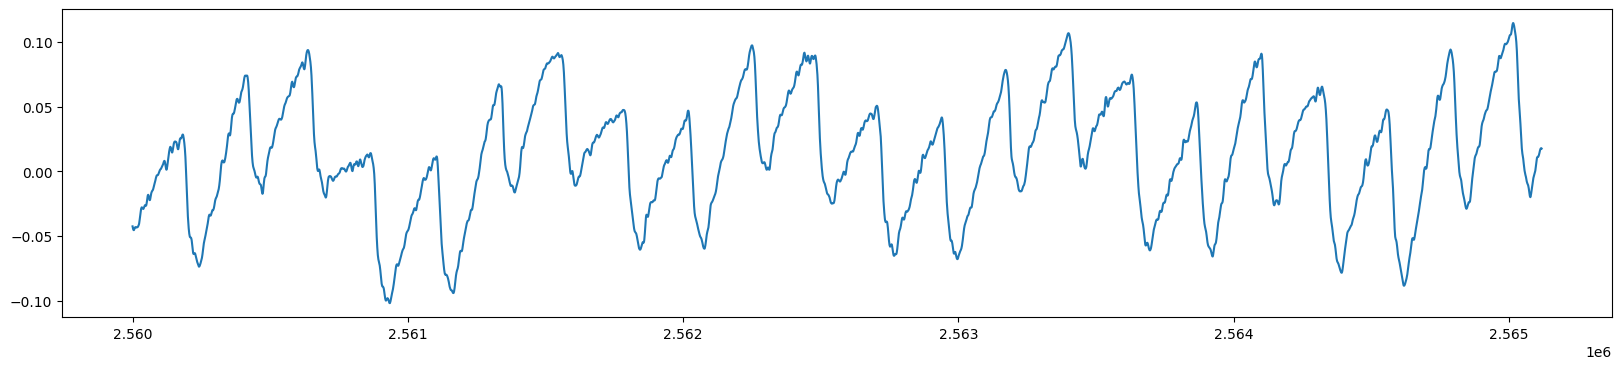

In [240]:
x.plot(figsize=(20, 4))

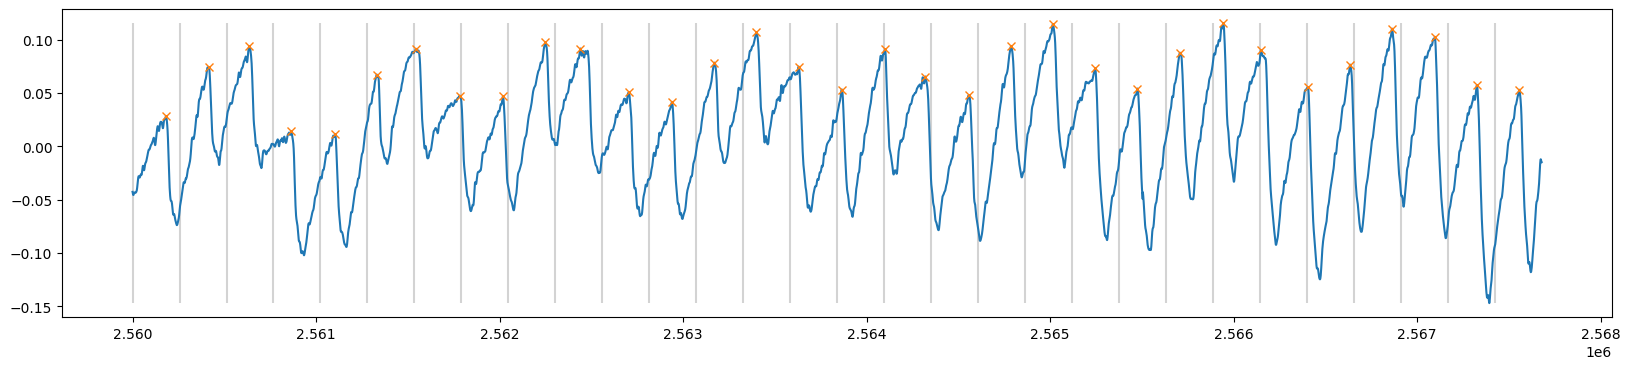

In [241]:
FREQ = 256
def show_seconds(ts, window=20):
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    start, end = ts*FREQ, (ts+window)*FREQ
    ax.vlines(list(range(start, end, FREQ)), ymin=pleth[start:end].min(), ymax=pleth[start:end].max(), colors='lightgrey')
    pleth[start:end].plot(ax=ax)

    peaks, _ = find_peaks(pleth[start:end].values, width=0.1*FREQ, distance=0.3*FREQ)
    ax.plot(peaks+start, pleth[start:end].values[peaks], "x")
    plt.show()

show_seconds(10000, 30)

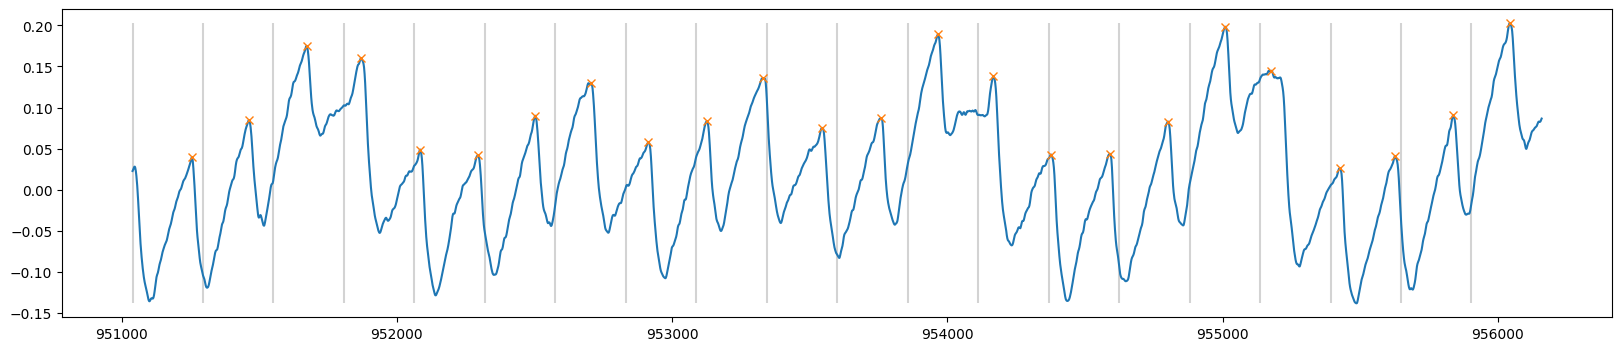

In [242]:
show_seconds(np.random.randint(len(pleth)//FREQ-100*FREQ), 20)

<Axes: >

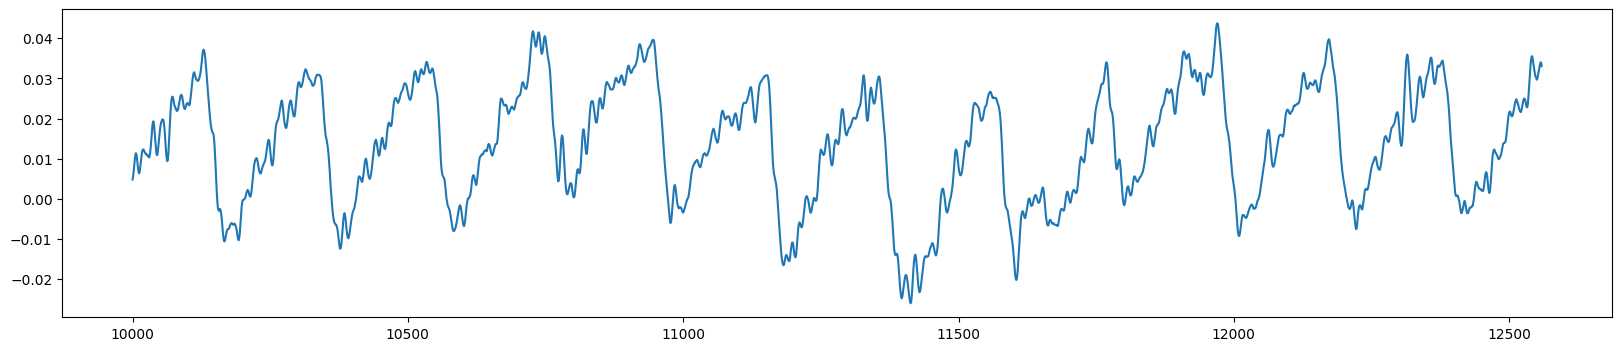

In [243]:
pleth[10000:10000+10*FREQ].plot(figsize=(20, 4))

<Axes: >

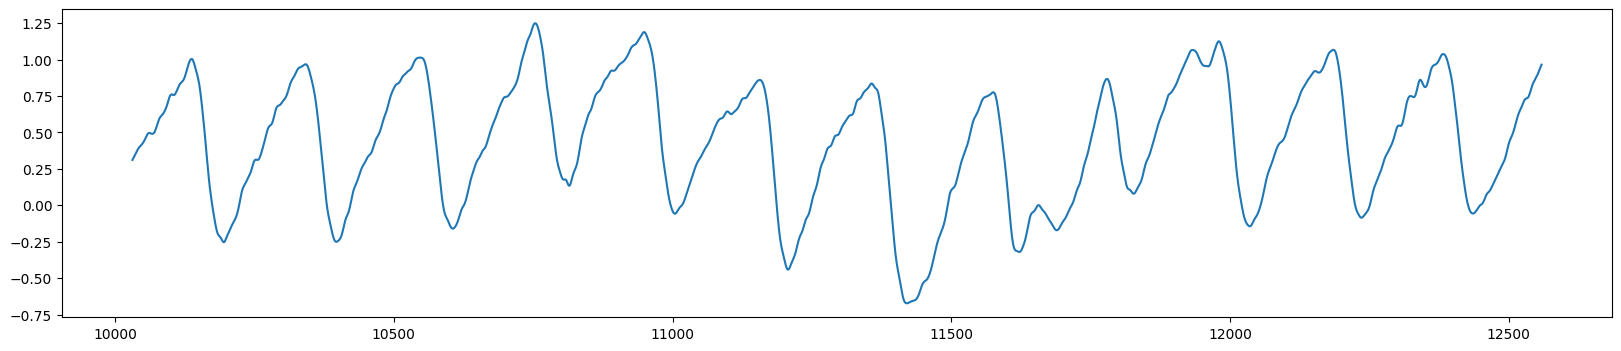

In [244]:
pleth[10000:10000+10*FREQ].rolling(32).sum().plot(figsize=(20, 4))

3097


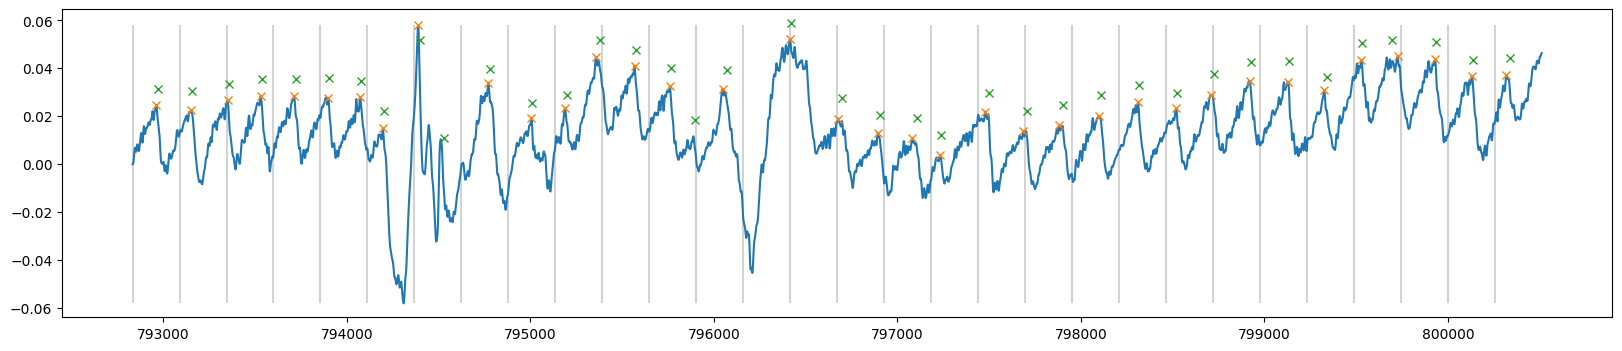

In [245]:
FREQ = 256
def show_seconds(ts, window=20):
    print(ts)
    _, ax = plt.subplots(1, 1, figsize=(20, 4))
    start, end = ts*FREQ, (ts+window)*FREQ

    signal = pleth[start:end]
    signal_smooth = signal.rolling(32).mean()
    mn, mx = signal.min(), signal.max()

    ax.vlines(list(range(start, end, FREQ)), ymin=mn, ymax=mx, colors='lightgrey')

    signal.plot(ax=ax)

    peaks, _ = find_peaks(signal.values, width=0.1*FREQ, distance=0.3*FREQ)
    peaks_smooth, _ = find_peaks(signal_smooth.values, width=0.1*FREQ, distance=0.3*FREQ)

    ax.plot(peaks+start, signal.values[peaks], "x")
    ax.plot(peaks_smooth+start, signal_smooth.values[peaks_smooth]+.01, "x")

    plt.show()

show_seconds(3097, 30)

460


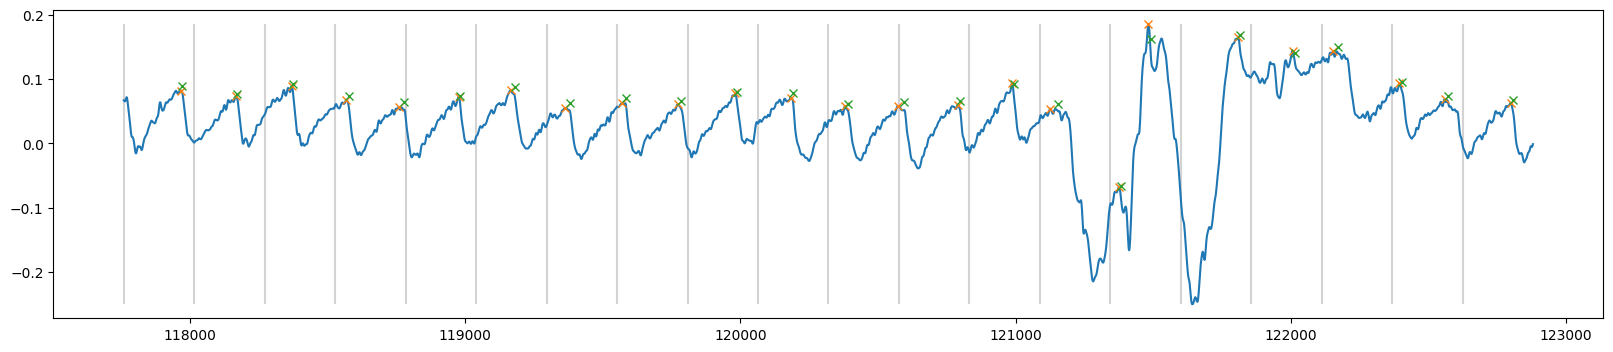

In [246]:
show_seconds(np.random.randint(len(pleth)//FREQ-100*FREQ), 20)

<Axes: >

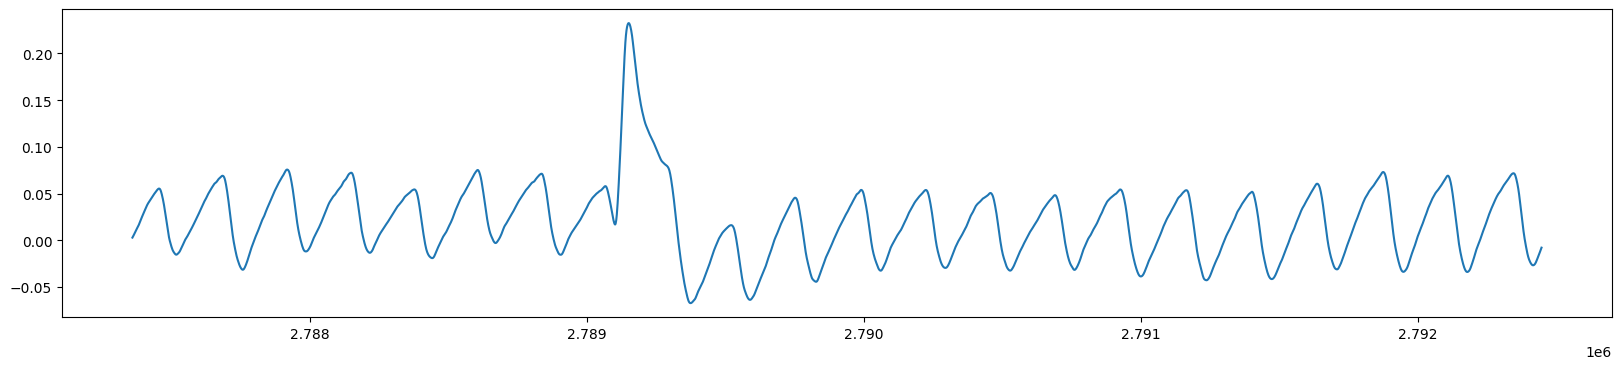

In [247]:
pleth[10888*256:10908*256].rolling(32).mean().plot(figsize=(20, 4))

### Test every value

5120


<Axes: >

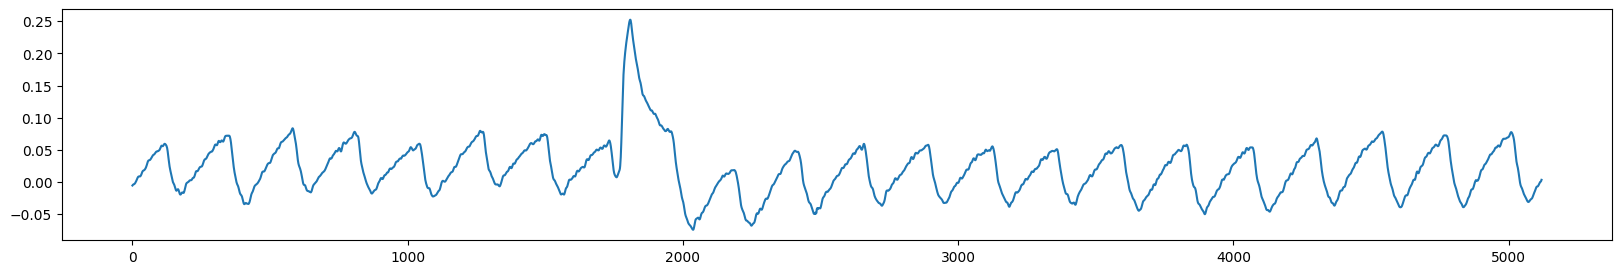

In [248]:
signal = pd.Series(pleth[10888*256:10908*256].values)
print(len(signal))
signal.plot(figsize=(20, 3))

In [249]:
def mean_peak_interval(peaks_df, fs=256):
    peaks = peaks_df[peaks_df == 1].index.values
    if len(peaks) < 2:
        return 0.0
    intervals_sec = np.diff(peaks) / fs
    return np.mean(intervals_sec)

def get_features(signal, window_in_sec=5, freq=FREQ):
    window_size = window_in_sec * freq
    rolling_signal = signal.rolling(window=window_size, min_periods=1, center=True)
    rolling_mean = rolling_signal.mean()
    rolling_std  = rolling_signal.std()
    rolling_min  = rolling_signal.min()
    rolling_max  = rolling_signal.max()
    peaks, _ = find_peaks(signal.rolling(32).mean().values, width=0.1*FREQ, distance=0.3*FREQ)
    peaks_df = pd.Series(0, index=range(len(signal)))
    peaks_df[peaks] = 1
    rolling_peak = peaks_df.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: mean_peak_interval(x), raw=False)
    return pd.DataFrame({
        'mean': rolling_mean,
        'std':  rolling_std,
        'min':  rolling_min,
        'max':  rolling_max,
        'peak': rolling_peak
    }).iloc[::freq].reset_index(drop=True)

<Axes: >

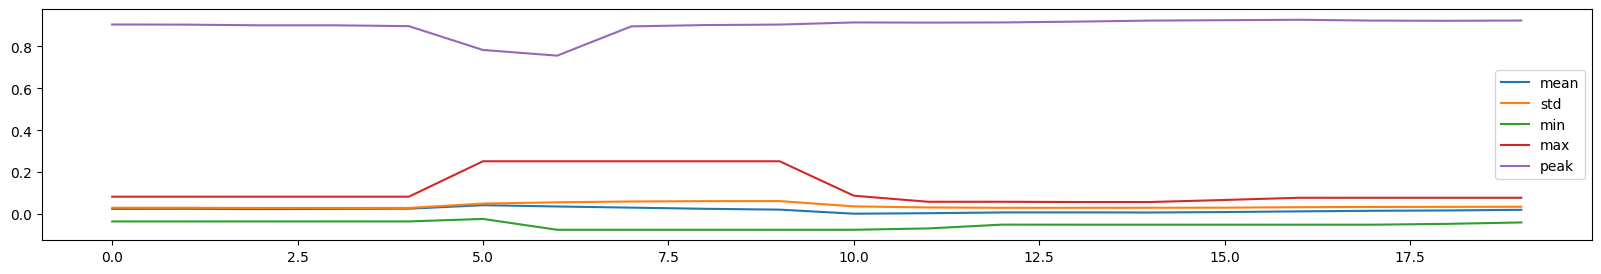

In [250]:
get_features(signal).plot(figsize=(20, 3))

In [251]:
peaks, _ = find_peaks(signal.rolling(32).mean().values, width=0.1*FREQ, distance=0.3*FREQ)

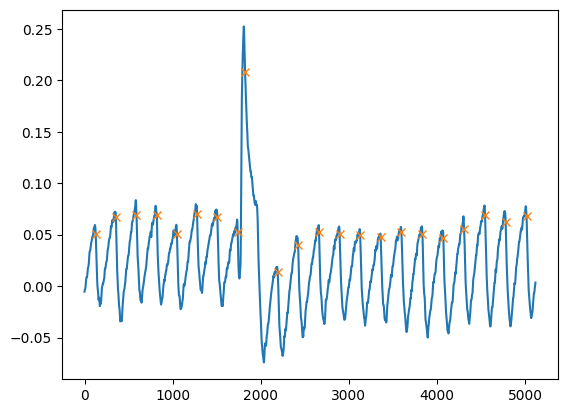

In [252]:
plt.plot(signal)
plt.plot(peaks, signal[peaks], "x")
plt.show()

In [253]:
print(peaks)
print(np.array([b-a for a, b in zip(peaks, peaks[1:])]))

[ 127  356  590  821 1049 1278 1508 1739 1823 2193 2424 2662 2896 3129
 3362 3598 3836 4074 4309 4547 4781 5018]
[229 234 231 228 229 230 231  84 370 231 238 234 233 233 236 238 238 235
 238 234 237]


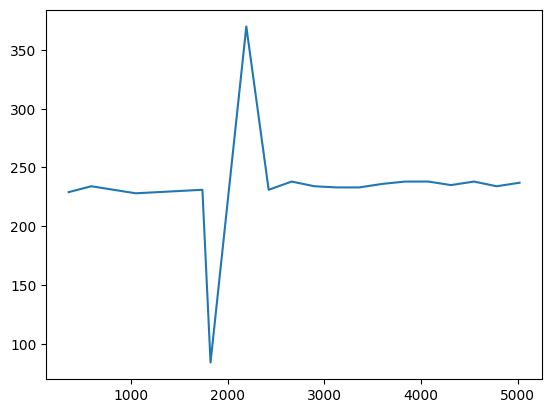

In [254]:
plt.plot(peaks[1:], np.array([b-a for a, b in zip(peaks, peaks[1:])]))

In [255]:
peaks

array([ 127,  356,  590,  821, 1049, 1278, 1508, 1739, 1823, 2193, 2424,
       2662, 2896, 3129, 3362, 3598, 3836, 4074, 4309, 4547, 4781, 5018])

In [256]:
np.mean(np.diff(peaks) / 256)

np.float64(0.9097842261904762)

100%|██████████| 20/20 [00:00<00:00, 18228.18it/s]


<Axes: >

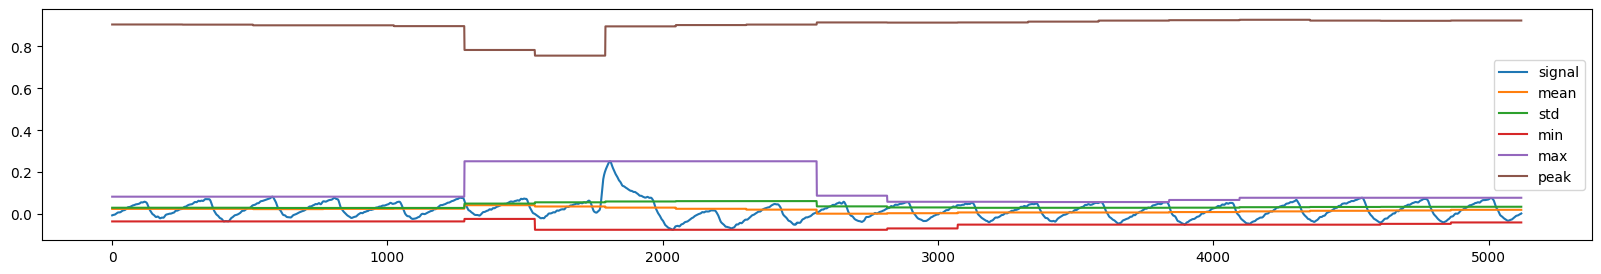

In [257]:
# Example for show how the values work
from tqdm import tqdm

features = get_features(signal)

list_mean = []
list_std  = []
list_min  = []
list_max  = []
list_peak = []

for sec_idx in tqdm(range(len(features))):
    second = features.iloc[sec_idx]
    list_mean += [second['mean']]*FREQ
    list_std  += [second['std']]*FREQ
    list_min  += [second['min']]*FREQ
    list_max  += [second['max']]*FREQ
    list_peak += [second['peak']]*FREQ

df = pd.DataFrame({
    'signal': signal,
    'mean': list_mean,
    'std':  list_std,
    'min':  list_min,
    'max':  list_max,
    'peak': list_peak
})

df.plot(figsize=(20, 3))

In [258]:
features = get_features(signal)
features

,mean,std,min,max,peak
0,0.025229,0.030806,-0.034409,0.083543,0.904297
1,0.025676,0.030765,-0.034409,0.083543,0.903646
2,0.024188,0.029666,-0.034409,0.083543,0.900391
3,0.025371,0.029732,-0.034409,0.083543,0.900391
4,0.026111,0.029854,-0.034409,0.083543,0.896484
5,0.042949,0.050623,-0.022507,0.252308,0.782813
6,0.036776,0.056683,-0.074235,0.252308,0.755859
7,0.031388,0.060646,-0.074235,0.252308,0.895312
8,0.025783,0.062192,-0.074235,0.252308,0.901563
9,0.021759,0.062500,-0.074235,0.252308,0.903906


In [259]:
features.iloc[3]['mean']

np.float64(0.025371461814297704)

### Final

/tmp/ipykernel_3161966/320680147.py:15: PeakPropertyWarning: some peaks have a width of 0
  peaks, _ = find_peaks(signal.rolling(32).mean().values, width=0.1*FREQ, distance=0.3*FREQ)


<Axes: >

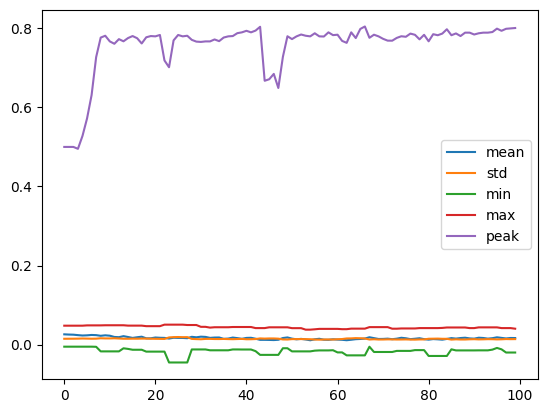

In [260]:
get_features(pleth[:256*100]).plot()

In [261]:
len(compute_rolling_peak(pleth[:256*100], 2))

100

<Axes: >

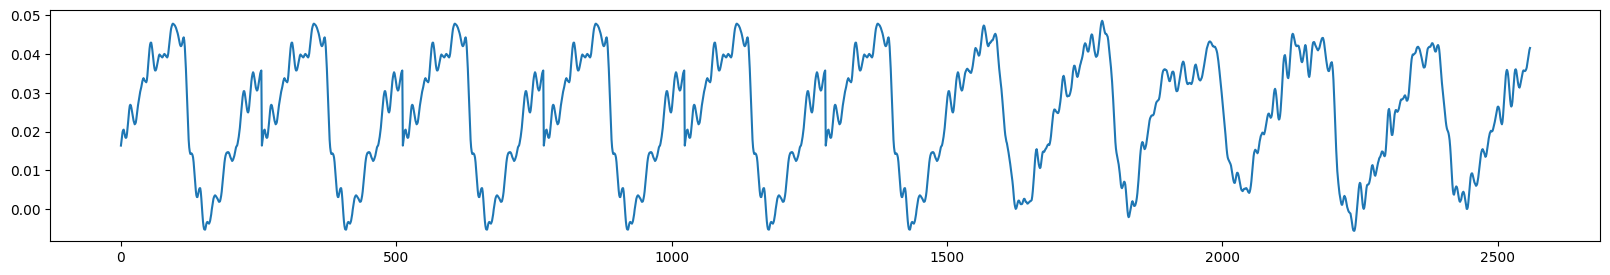

In [262]:
pleth[:256*10].plot(figsize=(20, 3))

In [263]:
from wearsed.dataset.utils import to_clock

def mean_peak_interval(signal, fs=FREQ):
    peaks, _ = find_peaks(signal.values, width=0.1*FREQ, distance=0.3*FREQ)
    if len(peaks) < 2:
        return 0.0
    intervals_sec = np.diff(peaks) / fs
    return np.mean(intervals_sec)

def compute_rolling_peak(signal, window_around_in_sec, freq=FREQ):
    rolling_peak = []
    signal_smooth = signal.rolling(32).mean()
    for sec_idx in range(len(signal)//freq):
        start, end = (sec_idx-window_around_in_sec)*256, (sec_idx+1+window_around_in_sec)*256
        start, end = max(0, start), min(len(signal), end)
        signal_window = signal_smooth[start:end]
        rolling_peak.append(mean_peak_interval(signal_window))
    return np.array(rolling_peak)

def get_features(signal, window_in_sec=5, freq=FREQ):
    window_size = window_in_sec * freq
    rolling_signal = signal.rolling(window=window_size, min_periods=1, center=True)
    rolling_mean = rolling_signal.mean()
    rolling_std  = rolling_signal.std()
    rolling_min  = rolling_signal.min()
    rolling_max  = rolling_signal.max()
    features = pd.DataFrame({
        'mean': rolling_mean.reset_index(drop=True),
        'std':  rolling_std.reset_index(drop=True),
        'min':  rolling_min.reset_index(drop=True),
        'max':  rolling_max.reset_index(drop=True)
    }).iloc[::freq].reset_index(drop=True)
    #peaks, _ = find_peaks(signal.rolling(32).mean().values, width=0.1*FREQ, distance=0.3*FREQ)
    #peaks_df = pd.Series(0, index=range(len(signal)))
    #peaks_df[peaks] = 1
    #rolling_peak = peaks_df.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: mean_peak_interval(x), raw=False)
    rolling_peak = compute_rolling_peak(signal, window_in_sec//2, freq=freq)
    features['peak'] = rolling_peak
    return features

def show_features(start=None, window_size=20):
    start = np.random.randint(len(pleth)//FREQ-window_size)*FREQ if start == None else start*FREQ
    print(f'{start} ({to_clock(start//FREQ, detail=False)})')
    signal = pleth[start:start+window_size*FREQ]
    features = get_features(signal)

    list_mean = []
    list_std  = []
    list_min  = []
    list_max  = []
    list_peak = []

    for sec_idx in tqdm(range(len(features))):
        second = features.iloc[sec_idx]
        list_mean += [second['mean']]*FREQ
        list_std  += [second['std']]*FREQ
        list_min  += [second['min']]*FREQ
        list_max  += [second['max']]*FREQ
        list_peak += [second['peak']]*FREQ

    features = pd.DataFrame({
        'signal': signal,
        'mean': list_mean,
        'std':  list_std,
        'min':  list_min,
        'max':  list_max,
        'peak': list_peak
    })
    
    _, ax = plt.subplots(1, 1, figsize=(20, 4))
    ax.vlines(list(range(features.index.values[0], features.index.values[-1], FREQ)), ymin=features.min()['min'], ymax=features.max()['max'], colors='lightgrey')
    features[['signal', 'mean', 'std', 'min', 'max']].plot(ax=ax)
    ax2 = ax.twinx()
    features['peak'].plot(ax=ax2, color='black')
    plt.show()

/tmp/ipykernel_3161966/739869242.py:4: PeakPropertyWarning: some peaks have a width of 0
  peaks, _ = find_peaks(signal.values, width=0.1*FREQ, distance=0.3*FREQ)


<Axes: >

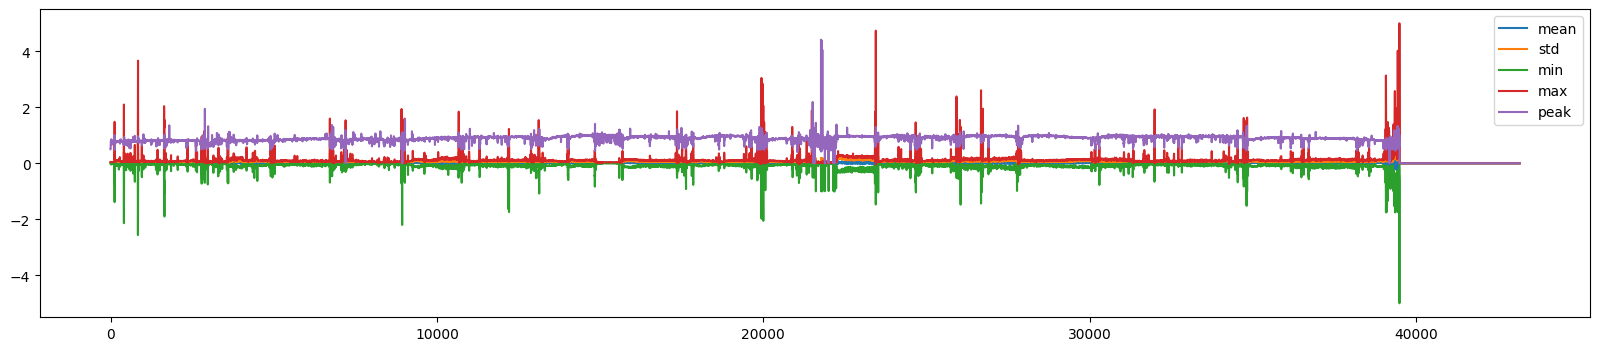

In [274]:
fs = get_features(pleth)
fs.plot(figsize=(20, 4))

<Axes: >

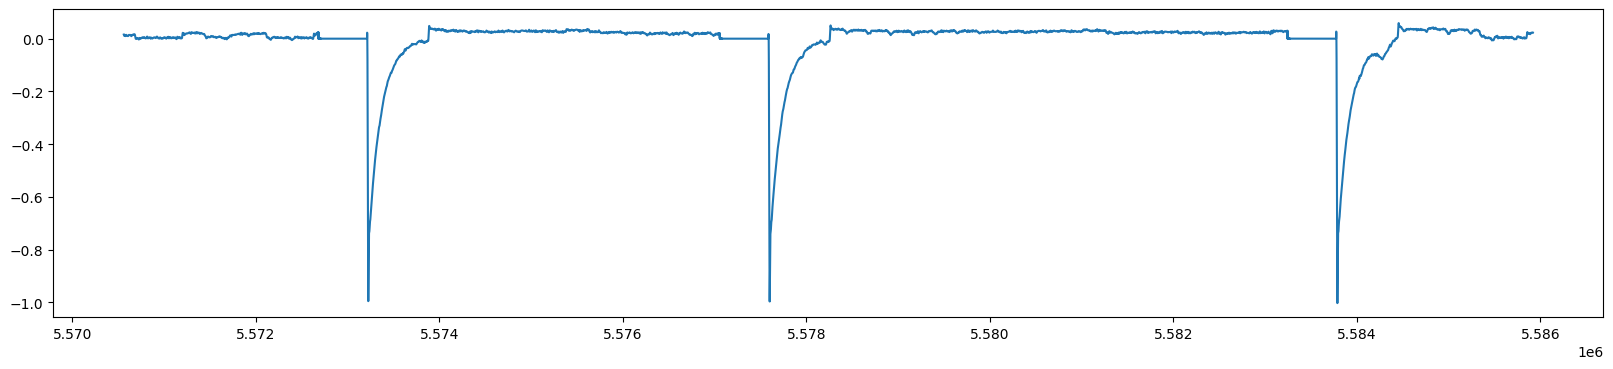

In [279]:
pleth[21760*FREQ:21820*FREQ].plot(figsize=(20, 4))

<Axes: >

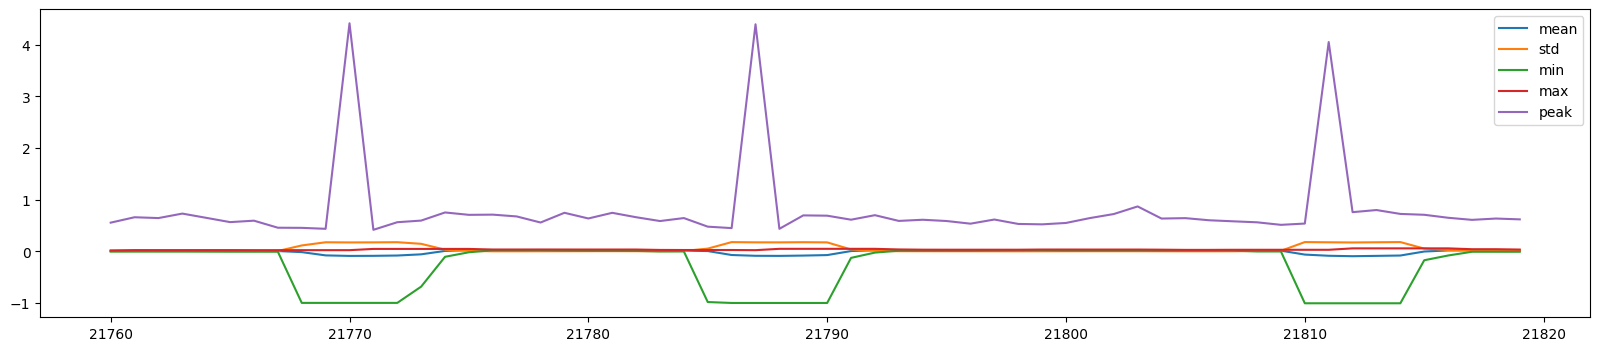

In [278]:
fs[21760:21820].plot(figsize=(20, 4))

In [264]:
len(pleth)/256

43179.0

In [265]:
38/1000*43179/60  # half an hour per 12h recording...

27.3467

In [266]:
43179/60/60

11.994166666666667

In [267]:
get_features(pleth[:256*100000])

/tmp/ipykernel_3161966/739869242.py:4: PeakPropertyWarning: some peaks have a width of 0
  peaks, _ = find_peaks(signal.values, width=0.1*FREQ, distance=0.3*FREQ)


,mean,std,min,max,peak
0,0.025952,0.014690,-0.005264,0.047837,0.500000
1,0.025377,0.014819,-0.005264,0.047837,0.500000
2,0.025058,0.014881,-0.005264,0.047837,0.500000
3,0.023941,0.015046,-0.005264,0.047837,0.500000
4,0.022971,0.015406,-0.005264,0.047837,0.537946
...,...,...,...,...,...
43174,0.000076,0.000000,0.000076,0.000076,0.000000
43175,0.000076,0.000000,0.000076,0.000076,0.000000
43176,0.000076,0.000000,0.000076,0.000076,0.000000
43177,0.000076,0.000000,0.000076,0.000076,0.000000


3678464 (03:59:29)


100%|██████████| 20/20 [00:00<00:00, 15180.25it/s]


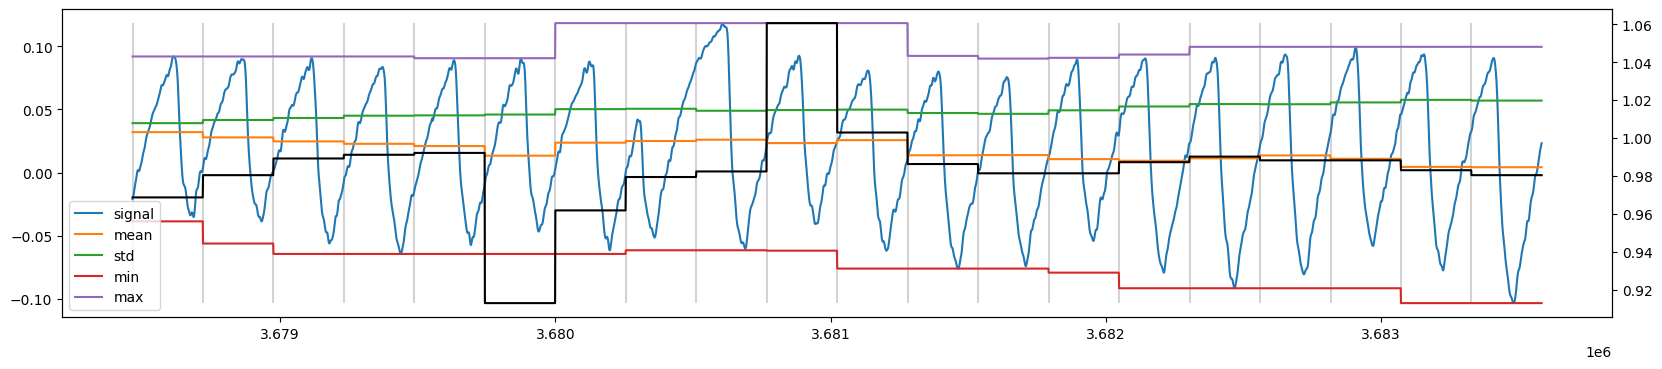

In [268]:
show_features()

<Axes: >

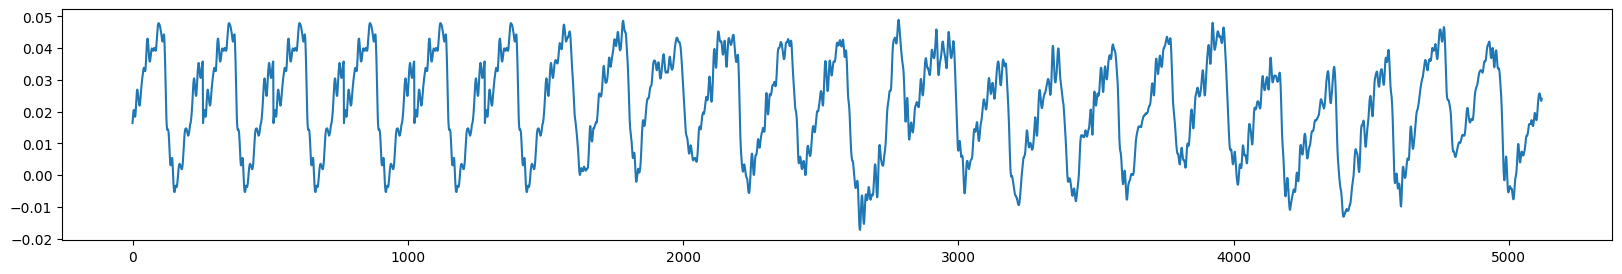

In [269]:
s = pleth[:256*20]
s.plot(figsize=(20, 3))

array([ 116,  255,  372,  511,  628,  767,  884, 1023, 1140, 1279, 1396,
       1592, 1792, 1995, 2154, 2396, 2586, 2792, 2970, 3173, 3370, 3575,
       3774, 3968, 4161, 4369, 4567, 4769, 4944])

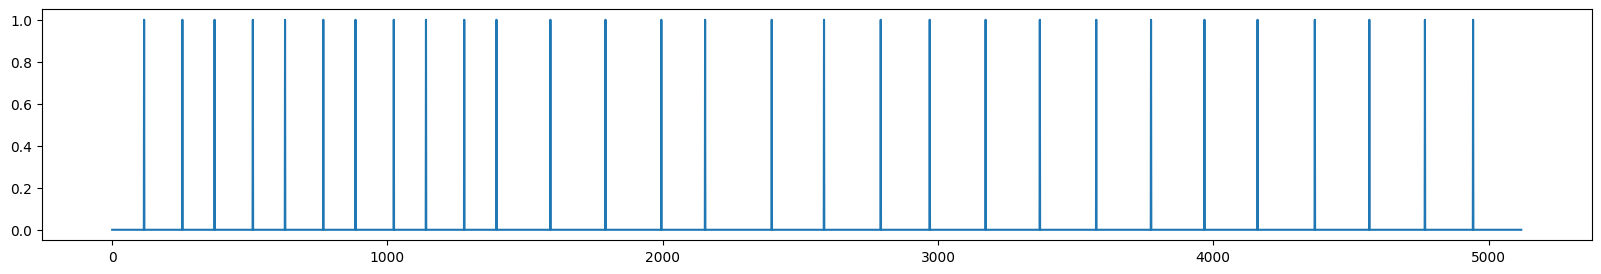

In [270]:
peaks, _ = find_peaks(s.rolling(32).mean().values, width=0.1*FREQ, distance=0.3*FREQ)
peaks_series = pd.Series(0., index=range(len(signal)))
peaks_series[peaks] = 1
peaks_series.plot(figsize=(20, 3))
peaks_series[peaks_series == 1].index.values

In [271]:
peaks_series[peaks_series == 1].index.values

array([ 116,  255,  372,  511,  628,  767,  884, 1023, 1140, 1279, 1396,
       1592, 1792, 1995, 2154, 2396, 2586, 2792, 2970, 3173, 3370, 3575,
       3774, 3968, 4161, 4369, 4567, 4769, 4944])